In [109]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

The country predicted to win the most medals in 2024 is: USA
     NOC  predictions
749  USA           89
307  GER           58
131  CHN           48
25   AUS           40
367  ITA           38
..   ...          ...
47   AUT            1
733  UKR            1
249  FIN            1
65   BEL            1
527  NOR            1

[63 rows x 2 columns]


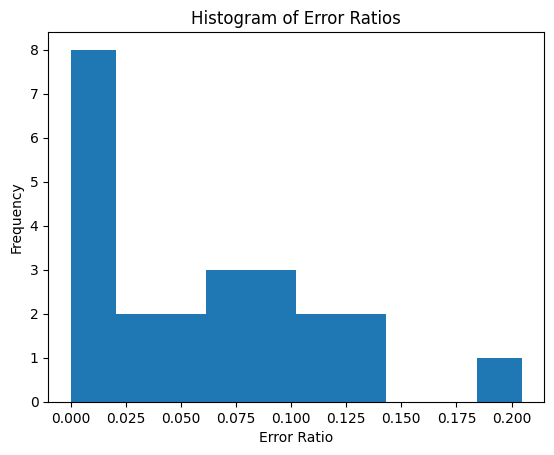

Error Ratios sorted:
NOC
AUT    0.000000
POL    0.000000
JPN    0.000000
FIN    0.000000
CZE    0.000000
DEN    0.000000
UKR    0.018182
ESP    0.019608
GER    0.032258
FRA    0.035714
NED    0.046512
KOR    0.050000
SUI    0.068182
CHN    0.073684
BUL    0.081081
SWE    0.086957
CAN    0.096774
NOR    0.100000
BEL    0.111111
HUN    0.117647
ITA    0.126984
AUS    0.140000
USA    0.204545
Name: Total, dtype: float64


In [108]:
df = []
file_paths = ['/Users/haresh.sam/Documents/dataset/archive/Lillehammer 1994 Olympics Nations Medals.csv',
              '/Users/haresh.sam/Documents/dataset/archive/Atlanta 1996 Olympics Nations Medals.csv',
              '/Users/haresh.sam/Documents/dataset/archive/Nagano 1998 Olympics Nations Medals.csv',
              '/Users/haresh.sam/Documents/dataset/archive/Sydney 2000 Olympics Nations Medals.csv',
              '/Users/haresh.sam/Documents/dataset/archive/SaltLakeCity 2002 Olympics Nations Medals.csv',
              '/Users/haresh.sam/Documents/dataset/archive/Athens 2004 Olympics Nations Medals.csv',
              '/Users/haresh.sam/Documents/dataset/archive/Torino 2006 Olympics Nations Medals.csv',
              '/Users/haresh.sam/Documents/dataset/archive/Vancouver 2010 Olympics Nations Medals.csv',
              '/Users/haresh.sam/Documents/dataset/archive/London 2012 Olympics Nations Medals.csv',
              '/Users/haresh.sam/Documents/dataset/archive/Sochi 2014 Olympics Nations Medals.csv',
              '/Users/haresh.sam/Documents/dataset/archive/Rio 2016 Olympics Nations Medals.csv',
              '/Users/haresh.sam/Documents/dataset/archive/PyeongChang 2018 Olympics Nations Medals.csv',
              '/Users/haresh.sam/Documents/dataset/archive/Tokyo 2020 Olympics Nations Medals.csv',
              '/Users/haresh.sam/Documents/dataset/archive/Beijing 2022 Olympics Nations Medals.csv',
              '/Users/haresh.sam/Documents/dataset/archive/Paris 2024 Olympics Nations Medals.csv']

years = [1994, 1996, 1998, 2000, 2002, 2004, 2006, 2010, 2012, 2014, 2016, 2018, 2020, 2022, 2024]
for file_path, year in zip(file_paths, years):
    table = pd.read_csv(file_path)
    table['Year'] = year
    df.append(table)
combined_df = pd.concat(df)
combined_df = combined_df.sort_values(by=['NOC'])
combined_df.reset_index(drop=True, inplace=True)

# Filter for specific NOCs
df1 = []
noc_codes = ['USA', 'CAN', 'GER', 'FRA', 'ITA', 'UKR', 'AUS', 'CHN', 'JPN', 'KOR', 'SWE', 'NOR', 'FIN', 'SUI', 'AUT', 'NED', 'POL', 'CZE', 'HUN', 'BUL', 'ROU', 'ESP', 'BEL', 'DEN', 'NZE']
for noc in noc_codes:
    country_row_df = combined_df[combined_df['NOC'] == noc]
    df1.append(country_row_df)
df2 = pd.concat(df1)

# Define predictors and target variable
predictors = ["Year", "Total"]
target = "Total"

# Split the data into training and test sets (80% training, 20% testing)
teams = df2[["NOC", "Gold", "Silver", "Bronze", "Total", "Year"]]
train = teams[teams["Year"] < 2018].copy()
test = teams[teams["Year"] >= 2020].copy()
train, test = train_test_split(df2, test_size=0.2, random_state=42)

# Initialize and train the model
reg = RandomForestClassifier()
reg.fit(train[predictors], train[target])

# Make predictions on the test set
predictions = reg.predict(test[predictors])
test["predictions"] = predictions
test.loc[test["predictions"] < 0, "predictions"] = 0
test["predictions"] = test["predictions"].round()

# Convert the total medals into categorical classes (e.g., low, medium, high)
bins = [0, 10, 30, np.inf]
labels = ["low", "medium", "high"]
test['Total_class'] = pd.cut(test[target], bins=bins, labels=labels)
test['Predictions_class'] = pd.cut(test['predictions'], bins=bins, labels=labels)

winner = test.loc[test["predictions"].idxmax(), "NOC"]
print(f"The country predicted to win the most medals in 2024 is: {winner}")
sorted_predictions = test.sort_values(by="predictions", ascending=False)
print(sorted_predictions[["NOC", "predictions"]])

# Analyze errors
errors = (test[target] - predictions).abs()
error_by_team = errors.groupby(test["NOC"]).mean()
medals_by_team = test[target].groupby(test["NOC"]).mean()
error_ratio = error_by_team / medals_by_team 
error_ratio = error_ratio[np.isfinite(error_ratio)]

# Plot histogram of error ratios
error_ratio.plot.hist()
plt.title('Histogram of Error Ratios')
plt.xlabel('Error Ratio')
plt.ylabel('Frequency')
plt.show()

# Sort and display error ratios
print("Error Ratios sorted:")
print(error_ratio.sort_values())


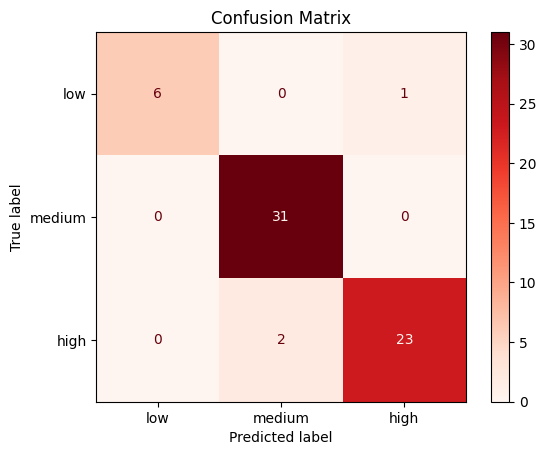

              precision    recall  f1-score   support

        high       1.00      0.86      0.92         7
         low       0.94      1.00      0.97        31
      medium       0.96      0.92      0.94        25

    accuracy                           0.95        63
   macro avg       0.97      0.93      0.94        63
weighted avg       0.95      0.95      0.95        63



In [110]:
#Confusion Matrix
cm = confusion_matrix(test['Total_class'], test['Predictions_class'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Reds)
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
report = classification_report(test['Total_class'], test['Predictions_class'])
print(report)